In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
from iuvs import io, scaling

In [3]:
def calc_4_to_3(width):
    height = width * 3 / 4
    return (width, height)

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.rcParams['figure.figsize']= calc_4_to_3(9)
plt.rcParams['image.aspect'] = 'auto'
plt.rcParams['image.interpolation'] = 'none'

# Why is the final image looking so different than the raw?

In [122]:
io.l1b_filenames()

['/Users/klay6683/data/iuvs/level1b/mvn_iuv_l1b_apoapse-orbit00107-mode2001-fuv_20141018T091335_v01_r01.fits.gz',
 '/Users/klay6683/data/iuvs/level1b/mvn_iuv_l1b_apoapse-orbit00107-mode2001-fuv_20141018T091856_v01_r01.fits.gz',
 '/Users/klay6683/data/iuvs/level1b/mvn_iuv_l1b_apoapse-orbit00107-mode2001-muv_20141018T091335_v01_r01.fits.gz',
 '/Users/klay6683/data/iuvs/level1b/mvn_iuv_l1b_apoapse-orbit00107-mode2001-muv_20141018T091856_v01_r01.fits.gz',
 '/Users/klay6683/data/iuvs/level1b/mvn_iuv_l1b_apoapse-orbit00108-mode2001-fuv_20141018T135038_v01_r01.fits.gz',
 '/Users/klay6683/data/iuvs/level1b/mvn_iuv_l1b_apoapse-orbit00108-mode2001-muv_20141018T135038_v01_r01.fits.gz',
 '/Users/klay6683/data/iuvs/level1b/mvn_iuv_l1b_apoapse-orbit00109-mode2001-fuv_20141018T182740_v01_r01.fits.gz',
 '/Users/klay6683/data/iuvs/level1b/mvn_iuv_l1b_apoapse-orbit00109-mode2001-muv_20141018T182740_v01_r01.fits.gz',
 '/Users/klay6683/data/iuvs/level1b/mvn_iuv_l1b_cruisecal2-mode070-muv_20140521T080545_v

In [210]:
indexes = [0, 2, 9, 10, 11, 12, 15, 16, 1, 3]

In [5]:
def get_title(l1b):
    return os.path.basename(l1b.fname)[12:-16]

In [163]:
import os

def get_img_dark_light(l1b):
    if l1b.img.ndim == 3:
        img = l1b.img[-1]
    else:
        img = l1b.img
    if l1b.detector_raw.ndim == 3:
        raw = l1b.detector_raw[-1]
    else:
        raw = l1b.detector_raw
    if l1b.detector_dark.ndim == 3:
        dark = l1b.detector_dark[-1]
    else:
        dark = l1b.detector_dark
    return img, raw, dark

def show_image_overview(l1b):
    fig, axes = plt.subplots(nrows=2)
    img, raw, dark = get_img_dark_light(l1b)
    # raw
    vmin, vmax = np.percentile(raw, (2,98))
    im = axes[0].imshow(raw, vmin=vmin, vmax=vmax)
    cb = plt.colorbar(im, ax=axes[0])
    for t in cb.ax.get_yticklabels():
        t.set_fontsize(13)
    axes[0].set_title("raw light")
    # dark
    vmin, vmax = np.percentile(dark, (2,98))
    im2 = axes[1].imshow(dark, vmin=vmin, vmax=vmax)
    cb = plt.colorbar(im2, ax=axes[1])
    for t in cb.ax.get_yticklabels():
        t.set_fontsize(13)
    axes[1].set_title('dark')
    fig.suptitle("{} INT_TIME: {}\nP2-P98 stretch. SPA_BIN:{}, SPE_BIN:{}"
                 .format(get_title(l1b),
                         l1b.img_header['INT_TIME'],
                         l1b.img_header['SPA_SIZE'],
                         l1b.img_header['SPE_SIZE']),
                 fontsize=16)
    fig.savefig('plots/'+get_title(l1b)+'_1.png', dpi=150)

In [185]:
import numpy as np

def img_profile_and_stats(img, l1b, title, spatialslice, spectralslice,
                          zmin=None, zmax=None, 
                          spatial=None, spectral=None,
                          ):
    fig, axes = plt.subplots(2, 2)
    if spatial is None:
        spatial = img.shape[0]//2
    if spectral is None:
        spectral = img.shape[1]//2

    
    no_nans = img[~np.isnan(img)]
    sliced = img[spatialslice, spectralslice]
    to_hist = sliced[~np.isnan(sliced)]
    if zmin is None:
        # set vis limits to 2, 98 percentile
        zmin, zmax = np.percentile(no_nans, (2, 98))

    prof1 = img[spatial]
    prof2 = img[:, spectral]
    axes = axes.ravel()
    im = axes[0].imshow(img, vmin=0, vmax=zmax)
    plt.colorbar(im, ax=axes[0])
    min_, max_ = np.percentile(prof2, (2,95))
    axes[1].plot(prof2)
    axes[1].set_ylim(min_, max_)
    axes[1].set_title('Spatial profile at middle spectral value')
    min_, max_ = np.percentile(prof1, (2,95))
    axes[2].plot(prof1)
    axes[2].set_ylim(min_, max_)
    axes[2].set_title('Spectral profile at middle spatial value')
    to_hist = to_hist[to_hist < zmax]
    to_hist = to_hist[to_hist > zmin]
    axes[3].hist(to_hist.ravel(), bins=50, log=False, normed=True)
    axes[3].set_title("Median: {:.1f}, STD: {:.1f}".format(np.median(to_hist),
                                                           to_hist.std()),
                      fontsize=12)
    fig.suptitle("{}, Slice: [{}:{}, {}:{}]\n Img stretch: (0, P98), prof stretch: (P2, P95)"
                 .format(get_title(l1b)+' '+title,
                         spatialslice.start,
                         spatialslice.stop,
                         spectralslice.start,
                         spectralslice.stop),
                 fontsize=16)
    if title == "LIGHT":
        no = 3
    else:
        no = 4
    fig.savefig('plots/'+get_title(l1b)+'_'+str(no)+'.png', dpi=150)

In [165]:
def poly_fitting(l1b, spatialslice, spectralslice):
    img, fullraw, fulldark = get_img_dark_light(l1b)
    light = fullraw[spatialslice, spectralslice]
    dark = fulldark[spatialslice, spectralslice]
    scaler = scaling.PolyScaler(dark, light)
    scaler.do_fit()
    return scaler.apply_fit(fulldark)

def plot_profiles(l1b, spatialslice, spectralslice):
    fig, axes = plt.subplots(nrows=4, sharex=True)
    axes = axes.ravel()
    img, light, dark = get_img_dark_light(l1b)
    spatial = img.shape[0]//2
    axes[0].semilogy(light[spatial])
    axes[0].set_title('light')
    axes[1].semilogy(dark[spatial])
    axes[1].set_title('dark')

    #fitting
    fitted_dark = poly_fitting(l1b, spatialslice, spectralslice)
    sub = light - fitted_dark
    min_, max_ = np.percentile(sub, (2, 92))
    if l1b.detector_background_subtracted.ndim == 3:
        backsub = l1b.detector_background_subtracted[0]
    else:
        backsub = l1b.detector_background_subtracted
    axes[2].plot(backsub[spatial])
    axes[2].set_ylim(min_, max_)
    axes[2].set_title('l1b subtracted')
    axes[3].plot(sub[spatial])
    axes[3].set_ylim(min_, max_)
    axes[3].set_title('subtracted with fitted dark')
    fig.suptitle("{} Slice: [{}:{}, {}:{}]\nprofile stretch: (P2, P92), fixed to newest for comparison"
                 .format(get_title(l1b),
                         spatialslice.start,
                         spatialslice.stop,
                         spectralslice.start,
                         spectralslice.stop),
                 fontsize=16)
    fig.savefig('plots/'+get_title(l1b)+'_2.png', dpi=150)
    return sub

In [103]:
plt.rcParams['figure.figsize'] = calc_4_to_3(12)

In [250]:
l1b = io.L1BReader(io.l1b_filenames()[1])

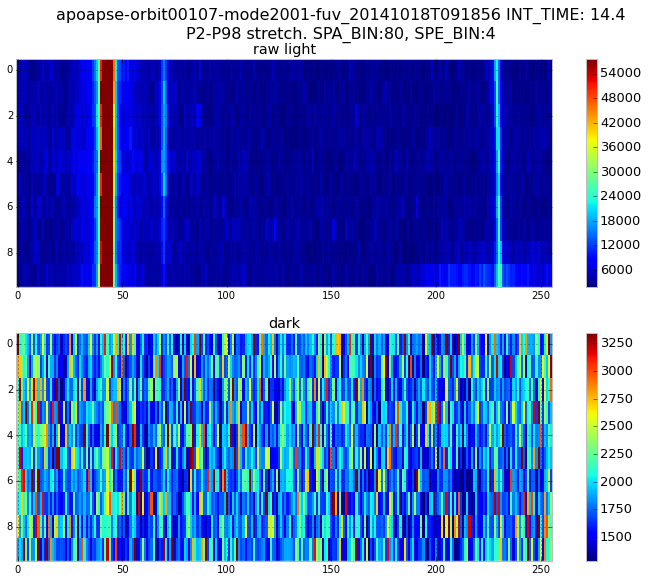

In [251]:
show_image_overview(l1b)

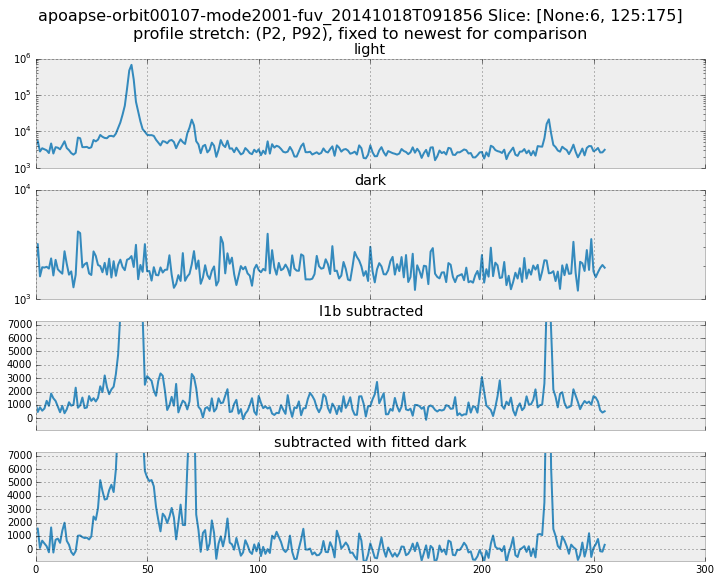

In [252]:
spa_slice = slice(None, 6)
spe_slice = slice(125, 175)
sub = plot_profiles(l1b, spa_slice, spe_slice)

In [253]:
l1b.detector_raw.shape

(21, 10, 256)

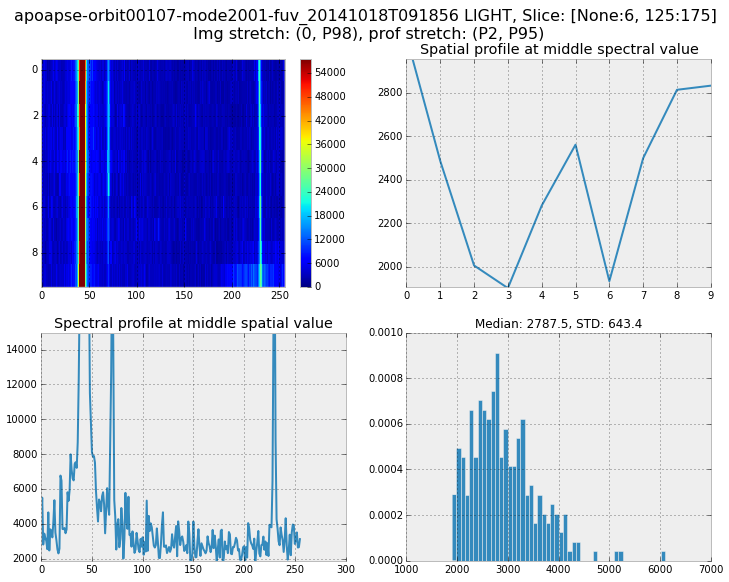

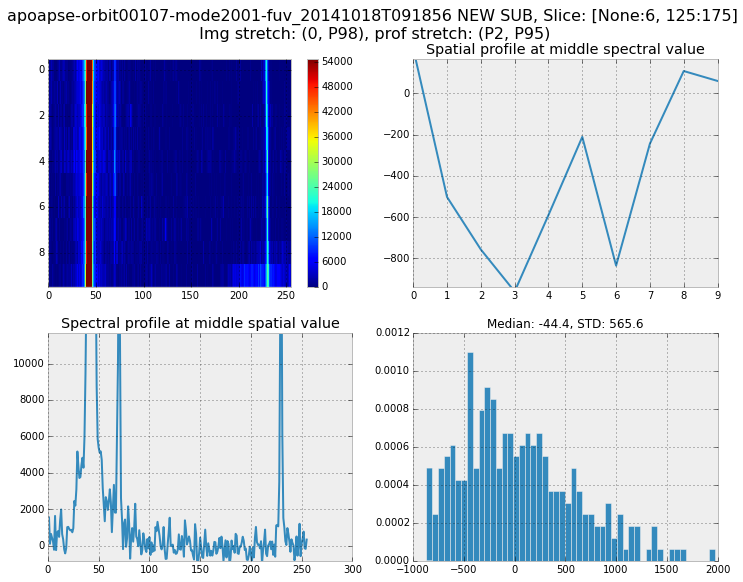

In [254]:
img_profile_and_stats(l1b.detector_raw[-1], l1b, 'LIGHT', spa_slice, spe_slice)
img_profile_and_stats(sub, l1b, 'NEW SUB', spa_slice, spe_slice)